# General Assembly Data Science Immersive, by Elliot Cohen
## Part 1
### Python Coding and Data Set

In [113]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

import sklearn
from sklearn import preprocessing
sklearn.__version__

'0.18.2'

In [2]:
# Load in the data file and header file provided
header_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/field_names.txt'
header_list = pd.read_csv(header_url, header=None, squeeze=True).tolist();

data_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/breast-cancer.csv'
data = pd.read_csv(data_url, header=None, names=header_list, index_col='ID')

In [3]:
# Comment on any steps you might take to evaluate or transform the dataset.
data.apply(pd.Categorical).describe()

,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
count,569,569.00,569.00,569.0,569.0,569.0000,569.0000,569.0,569.0,569.0000,...,569.00,569.00,569.0,569.0,569.0000,569.0000,569.0,569.0,569.0000,569.00000
unique,2,456.00,479.00,522.0,539.0,474.0000,537.0000,537.0,542.0,432.0000,...,457.00,511.00,514.0,544.0,411.0000,529.0000,539.0,492.0,500.0000,535.00000
top,B,12.34,18.22,134.7,512.2,0.1007,0.1147,0.0,0.0,0.1714,...,12.36,27.26,101.7,826.4,0.1216,0.1486,0.0,0.0,0.2383,0.07427
freq,357,4.00,3.00,3.0,3.0,5.0000,3.0000,13.0,13.0,4.0000,...,5.00,3.00,3.0,2.0,4.0000,3.0000,13.0,13.0,3.0000,3.00000


In [4]:
# Compute the mean and median smoothness and compactness for benign and malignant tumors
data.filter(regex='smoothness|compactness|diagnosis').groupby('diagnosis').agg(['mean', 'median'])

smoothness_mean         smoothness_sd_error          \
                     mean  median                mean  median   
diagnosis                                                       
B                2.000321  1.8510           21.135148  19.630   
M                4.323929  3.6795           72.672406  58.455   

          smoothness_worst           compactness_mean           \
                      mean    median             mean   median   
diagnosis                                                        
B                 0.007196  0.006530         0.021438  0.01631   
M                 0.006780  0.006209         0.032281  0.02859   

          compactness_sd_error           compactness_worst            
                          mean    median              mean    median  
diagnosis                                                             
B                     0.025997  0.018400          0.009858  0.009061  
M                     0.041824  0.037125          0.015060  0.014205

In [5]:
# Do the groups differ? Explain how you would identify this.
grouped = data.groupby('diagnosis')
malignant = data.loc[grouped.groups['M']]
benign = data.loc[grouped.groups['B']]

t, p = ttest_ind(malignant['smoothness_mean'], benign['smoothness_mean']) # T-test for the means of two independent samples.
print('{}: t statitic = {:.6f} p value = {:.9f}'.format('smoothness', t, p))

t, p = ttest_ind(malignant['compactness_mean'], benign['compactness_mean']) # T-test for the means of two independent samples.
print('{}: t statitic = {:.6f} p value = {:.9f}'.format('compactness', t, p))

smoothness: t statitic = 15.934158 p value = 0.000000000
compactness: t statitic = 7.297077 p value = 0.000000000


Grouping the cancer data by diagnosis, and summarizing by smoothness and compactness features, we see a discernable difference in measures of central tendancy (e.g. mean and median). To determine if this difference is statistically significant, we conduct a two-sided T-test with a null hypothesis that the two independent samples are identically distributed.

Results indicate that we can reject the null hypothesis that mean cell nuclei smoothness for benign and malignant tupors are the same, based on a p_value approaching zero. Similarly for compactness, we can reject the null hypthoses that benign and malignant cell nuclei compactness are the same.

In [6]:
# Write a function to generate bootstrap samples of the data.
def create_bootstrap_samples_from_dataframe(dataframe, n_samples=1000):
    assert isinstance(dataframe, pd.core.frame.DataFrame), 'input data must be a pandas dataframe'
    return dataframe.sample(n=n_samples, replace=True)

In [7]:
# example usage
bootstrap_data = create_bootstrap_samples_from_dataframe(data, n_samples=10000)

print('original smoothness for benign cells: {:.6f}'.format(data[data['diagnosis']=='B']['smoothness_mean'].mean()))
print('resampled smoothness for benign cells: {:.6f}'.format(bootstrap_data[bootstrap_data['diagnosis']=='B']['smoothness_mean'].mean()))

original smoothness for benign cells: 2.000321
resampled smoothness for benign cells: 1.998991


### Exploratory Analysis
Identify 2-3 variables that are predictive of a malignant tumor.  
Display the relationship visually and write 1-2 sentences explaining the relationship.

In [8]:
# divide data into predictors (X) and predictand (y)
x_train = data.iloc[:, data.columns != 'diagnosis']
y_train = data['diagnosis'].replace({'M': 1, 'B': 0}) # convert to binary outcome

In [10]:
# scale the x data
scaler = preprocessing.StandardScaler().fit(x_train)
x_train_scaled = scaler.transform(x_train)

tolerance = 1*10**-5
assert all(abs(x_train_scaled.mean(axis=0) - 0) <= tolerance) # verify that scaled mean ~=0
assert all(abs(x_train_scaled.std(axis=0) - 1) <= tolerance) # verify that scaled std ~=1

In [49]:
# Next use ridge regression, choosing the hyperparameter based on 10-fold cross-validation.
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import linear_model

classifier = linear_model.LogisticRegression(penalty='l1', class_weight='balanced')
probability_by_class = classifier.fit(x_train_scaled, y_train).predict_proba(x_train_scaled)
probability_malignant = probability_by_class[:,0] < 0.68

data['predicted_diagnosis'] = probability_malignant
data['predicted_diagnosis'] = data.predicted_diagnosis.replace({True: 'M', False: 'B'})

In [50]:
false_positives = data[(data['predicted_diagnosis'] == 'M') & (data['diagnosis'] == 'B')]
false_negatives = data[(data['predicted_diagnosis'] == 'B') & (data['diagnosis'] == 'M')]
type_1_error = len(false_positives)/len(data)
type_2_error = len(false_negatives)/len(data)

print('type 1 error rate: {:.5f}'.format(type_1_error))
print('type 2 error rate: {:.5f}'.format(type_2_error))

type 1 error rate: 0.01933
type 2 error rate: 0.00703


In a medical diagnostic setting, we would tune the probability threshold (currently set to 0.68) to optimize for type I or type II errors, accordingly.

In [52]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import linear_model


classifier = linear_model.LogisticRegression(penalty='l1', class_weight='balanced')
kfold = KFold(n_splits=10, shuffle=False)

param_grid = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0, 500.0, 1000.0]}

cv = GridSearchCV(classifier,
                  param_grid=param_grid,
                  scoring='neg_log_loss',
                  cv=kfold,
                  verbose=1)

cv.fit(x_train_scaled, y_train.values)
print("BEST: {} {}".format(cv.best_params_, cv.best_score_))

Fitting 10 folds for each of 13 candidates, totalling 130 fits
BEST: {'C': 0.5} -0.09071806977998241


[Parallel(n_jobs=1)]: Done 130 out of 130 | elapsed:   24.5s finished


In [85]:
from sklearn.feature_selection import SelectKBest, f_classif, chi2

# select top k predictors
k = 3
selector = SelectKBest(f_classif, k)
selector.fit(X=x_train_scaled, y=y_train)

idxs_selected = selector.get_support(indices=True) # get indices of columns to keep
best_predictors = x_train.columns[idxs_selected]
print('top {} predictors: {}'.format(k, best_predictors.values))

top 3 predictors: ['perimeter_sd_error' 'concave_points_sd_error' 'fractal_dimension_mean']


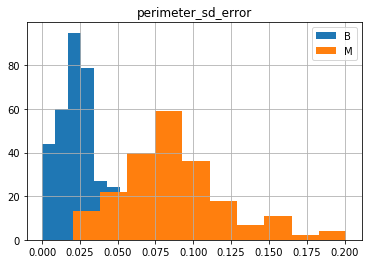

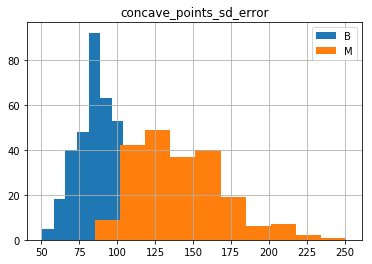

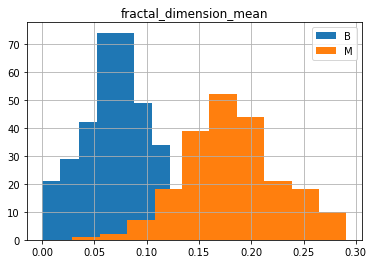

In [121]:
for predictor in best_predictors:
    for group in data.groupby('diagnosis'):
        group[1][predictor].hist(label=group[0])
        plt.title(predictor)
        plt.legend()
    plt.show()

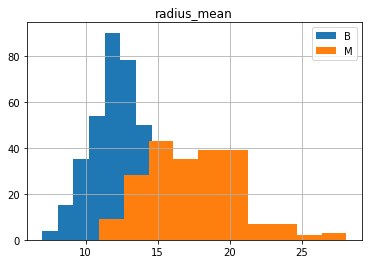

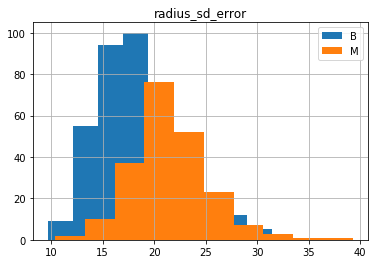

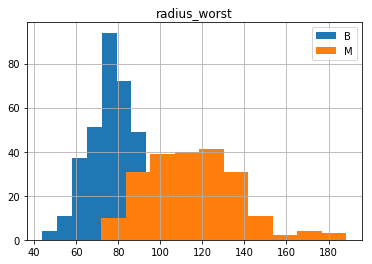

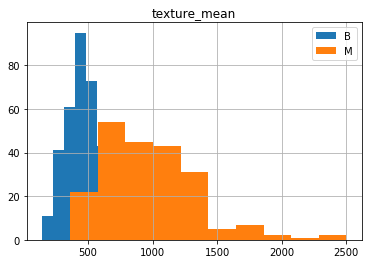

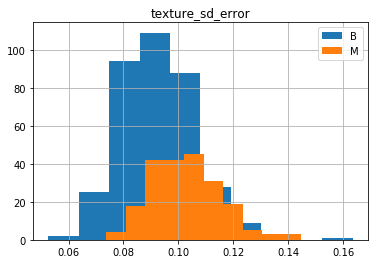

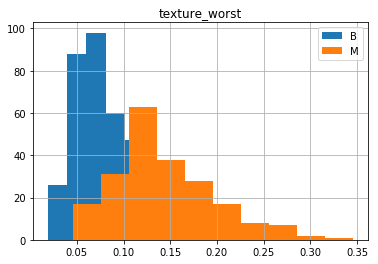

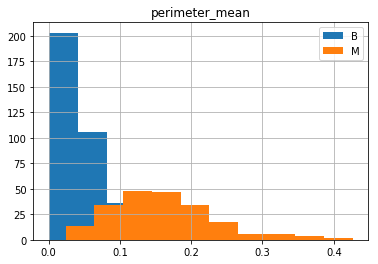

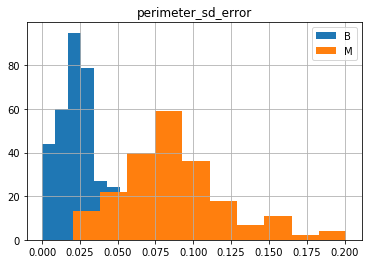

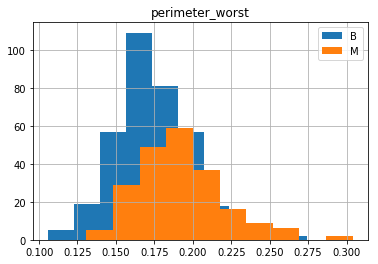

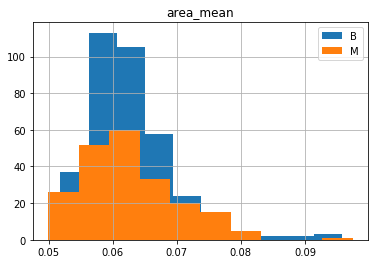

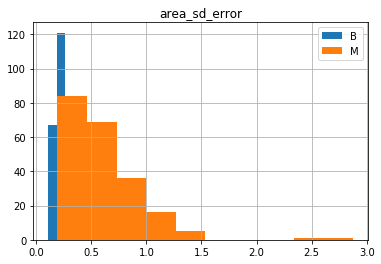

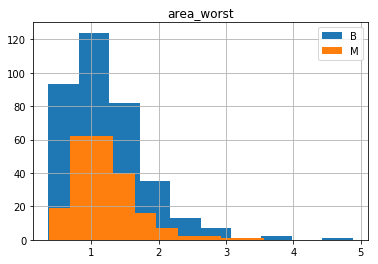

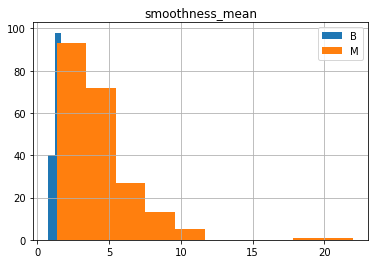

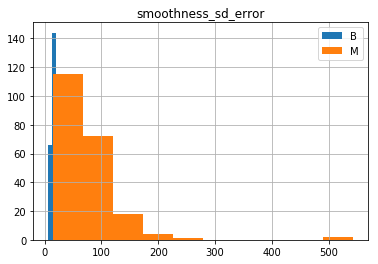

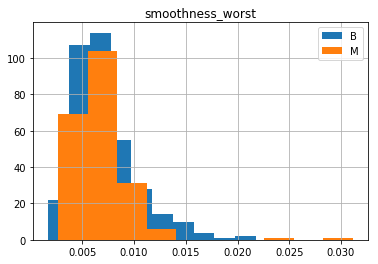

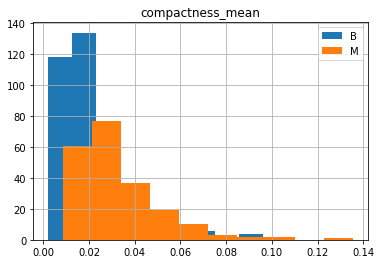

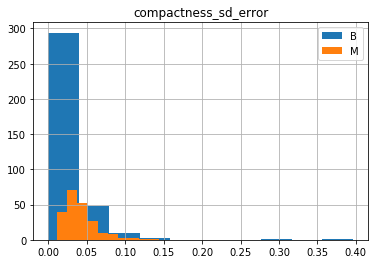

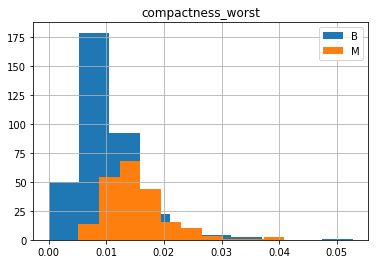

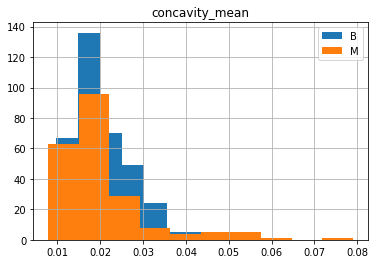

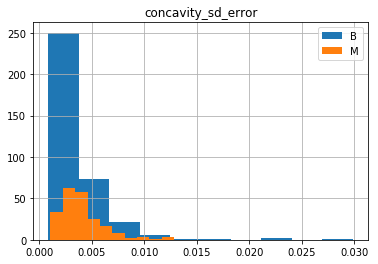

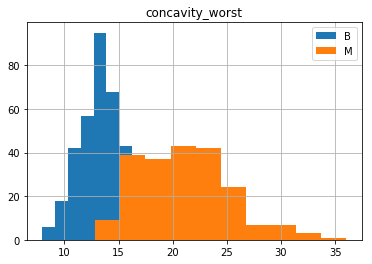

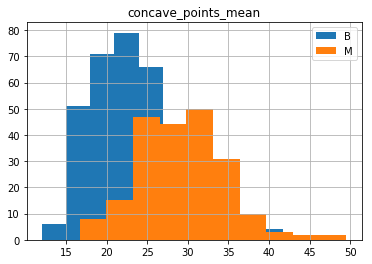

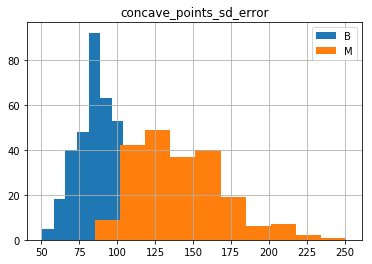

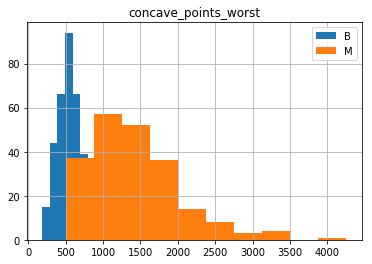

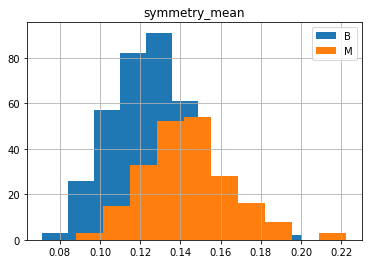

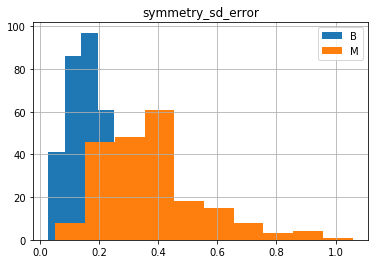

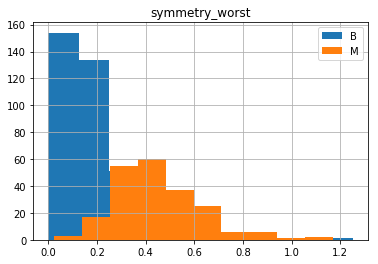

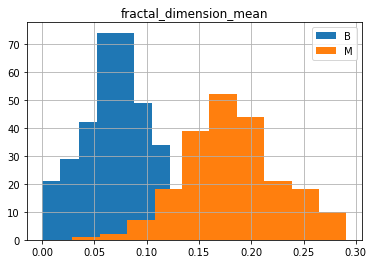

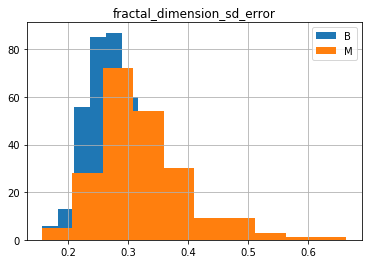

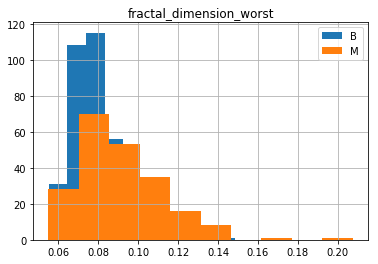

In [120]:
for predictor in data.select_dtypes(include=['float64']).columns:
    for group in data.groupby('diagnosis'):
        group[1][predictor].hist(label=group[0])
        plt.title(predictor)
        plt.legend()
    plt.show()

In [ ]:
final_classifier = cv.best_estimator_
final_classifier.fit(x_train_scaled, y_train.values)
coefficients = final_classifier.coef_
intercept = final_classifier.intercept_
final_classifier.predict_proba(x_train_scaled)

In [ ]:
data[data['diagnosis']=='M'].plot(kind='density', subplots=True, layout=(10,3), sharex=False, figsize=(18,18))
data[data['diagnosis']=='B'].plot(kind='density', subplots=True, layout=(10,3), sharex=False, figsize=(18,18))

In [ ]:
from sklearn.cluster import KMeans
X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
print(kmeans.labels_)
print(kmeans.predict([[0, 0], [4, 4]]))
print(kmeans.cluster_centers_)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [ ]:
import numpy as np
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

np.random.seed(1)

# Create sample data.
a = np.random.randn(40)
b = 4*np.random.randn(50)

# Use scipy.stats.ttest_ind.
t, p = ttest_ind(a, b, equal_var=False)
print("ttest_ind:            t = %g  p = %g" % (t, p))

# Compute the descriptive statistics of a and b.
abar = a.mean()
avar = a.var(ddof=1)
na = a.size
adof = na - 1

bbar = b.mean()
bvar = b.var(ddof=1)
nb = b.size
bdof = nb - 1

# Use scipy.stats.ttest_ind_from_stats.
t2, p2 = ttest_ind_from_stats(abar, np.sqrt(avar), na,
                              bbar, np.sqrt(bvar), nb,
                              equal_var=False)
print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))

# Use the formulas directly.
tf = (abar - bbar) / np.sqrt(avar/na + bvar/nb)
dof = (avar/na + bvar/nb)**2 / (avar**2/(na**2*adof) + bvar**2/(nb**2*bdof))
pf = 2*stdtr(dof, -np.abs(tf))

print("formula:              t = %g  p = %g" % (tf, pf))